In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import duckdb

from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation

ModuleNotFoundError: No module named 'pandas'

In [ ]:
Properties_df = pd.read_csv('realtor_data.csv')
Properties_df

,address/street,baths,beds,coordinates/latitude,coordinates/longitude,garage,id,listPrice,is_manual,name,sqft,status,stories,type,units,year_built
0,809 S Aurora St,2.0,5.0,42.430851,-76.496069,0,4208852367,2625.0,False,NaN,1300.0,for_rent,1,single_family,1,NaN
1,419 Triphammer Rd,2.0,6.0,42.460409,-76.481516,4,4733433667,5000.0,False,NaN,3200.0,for_rent,2,single_family,1,1956.0
2,517 S Aurora St,2.0,6.0,42.435014,-76.494344,0,4090421202,4350.0,False,NaN,2457.0,for_rent,1,single_family,1,NaN
3,3 Hudson Pl,1.0,2.0,42.430688,-76.493156,0,4199200488,1600.0,False,NaN,900.0,for_rent,1,single_family,1,NaN
4,600 Warren Rd Apt 4-2,1.5,1.5,42.477345,-76.467567,0,9934501911,1881.0,True,Warren Wood,894.0,for_rent,1,apartment,181,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,519 E Buffalo St,1.0,2.0,42.441285,-76.490701,0,3834217847,1200.0,False,"Moll Properties, Inc.",0.0,for_rent,1,other,7,NaN
229,106 Wiedmaier Ct,2.0,3.0,42.413681,-76.449093,0,3610937531,3244.0,True,Ithacor,1476.0,for_rent,1,apartment,2,2007.0
230,409 College Ave,1.0,1.5,42.442255,-76.484963,0,9523596613,4095.0,True,"Student Agencies Properties, Inc.",725.0,for_rent,1,apartment,64,NaN
231,103 Wiedmaier Ct,1.5,3.0,42.413895,-76.448010,0,3609558692,1450.0,True,Ithacor,1144.5,for_rent,1,apartment,2,2015.0


## Incoorporating spatial data

In [ ]:
Properties_Cornell_df = pd.read_csv("Datasets/OD_Summarized/Properties_Cornell.csv").drop(('OID_'), axis=1)
Properties_Cornell_df

,Total_PublicTransitTime,Properties_Name,Properties_DistanceToNetworkInMeters
0,32.964266,809 S Aurora St,39.605924
1,18.726652,419 Triphammer Rd,39.790883
2,27.153197,517 S Aurora St,17.950932
3,31.883101,3 Hudson Pl,37.485246
4,52.595182,600 Warren Rd Apt 4-2,56.739091
...,...,...,...
217,16.447236,519 E Buffalo St,40.144625
218,66.470373,106 Wiedmaier Ct,45.288278
219,9.072828,409 College Ave,32.997781
220,65.315703,103 Wiedmaier Ct,16.286313


In [ ]:
Properties_IC_df = pd.read_csv("Datasets/OD_Summarized/Properties_IC.csv").drop(('OID_'), axis=1)
Properties_IC_df

,Total_PublicTransitTime,Properties_Name,Properties_DistanceToNetworkInMeters
0,17.936731,0,40
1,67.913519,0,40
2,23.846284,0,18
3,17.827128,0,37
4,101.782050,0,57
...,...,...,...
217,36.659887,0,40
218,76.616162,0,45
219,40.637400,0,33
220,75.461492,0,16


In [ ]:
Properties_Schools_df = pd.read_csv("Datasets/OD_Summarized/Properties_Schools.csv").\
    drop(['OID_',
          'MAX_ODLines39kbyk_Total_PublicTransitTime',
          'MIN_ODLines39kbyk_Total_PublicTransitTime',
          'STD_ODLines39kbyk_Total_PublicTransitTime'], axis=1).\
    rename({'Origins1hcrswg_Name':'Properties_Name','FREQUENCY':'N_POI_within_90',
            'MEAN_ODLines39kbyk_Total_PublicTransitTime':'Mean_transit_Time'}, axis=1)
Properties_Schools_df

,Properties_Name,N_POI_within_90,Mean_transit_Time
0,1 Candlewyck Dr,9,61.801862
1,100 Graham Rd,10,57.304150
2,1002 N Aurora St,14,38.282461
3,1005 1007 N Aurora St,14,38.222978
4,101 Dryden Rd,14,39.441713
...,...,...,...
215,902 Dryden Rd,13,65.455279
216,918 Danby Rd,13,46.376722
217,918 Danby Road Llc 918 Danby Rd,13,46.457477
218,921 Taughannock Blvd,8,69.400313


In [ ]:
Properties_FoodDrink_df = pd.read_csv("Datasets/OD_Summarized/Properties_FoodDrink.csv").\
    drop(['OID_','MIN_Properties_FoodDrinks_OD_lt90_open_Total_PublicTransitTime',
          'MAX_Properties_FoodDrinks_OD_lt90_open_Total_PublicTransitTime',
          'STD_Properties_FoodDrinks_OD_lt90_open_Total_PublicTransitTime',
          'MAX_Properties_FoodDrinks_OD_lt90_open_Attraction_CostNormalized',
          'MAX_Properties_FoodDrinks_OD_lt90_open_Attraction_CostNormaliz_1',
          'STD_Properties_FoodDrinks_OD_lt90_open_Attraction_CostNormalized'], axis=1).\
    rename({'Origins15dqmd4_Name':'Properties_Name','FREQUENCY':'N_POI_within_90',
            'MEAN_Properties_FoodDrinks_OD_lt90_open_Total_PublicTransitTime':'Mean_Transit_Time',
            'MEAN_Properties_FoodDrinks_OD_lt90_open_Attraction_CostNormalize':'Mean_Attraction_CostNormalized'}, axis=1)
Properties_FoodDrink_df

,Properties_Name,N_POI_within_90,Mean_Transit_Time,Mean_Attraction_CostNormalized
0,1 Candlewyck Dr,244,56.029001,25.397547
1,1 Maplewood Rd,16,77.550050,122.182884
2,100 Graham Rd,212,70.944209,26.462377
3,1002 N Aurora St,278,29.609902,57.036398
4,1005 1007 N Aurora St,278,29.635181,58.376029
...,...,...,...,...
216,902 Dryden Rd,269,61.658983,19.478793
217,918 Danby Rd,260,33.274344,44.245821
218,918 Danby Road Llc 918 Danby Rd,260,33.383813,43.994344
219,921 Taughannock Blvd,226,62.681561,22.892277


In [ ]:
Properties_Groceries_df = pd.read_csv("Datasets/OD_Summarized/Properties_Groceries.csv").\
    drop(['OID_','MIN_Total_PublicTransitTime',
          'MAX_Total_PublicTransitTime',
          'STD_Total_PublicTransitTime',
          'MIN_Attraction_CostNormalized',
          'MAX_Attraction_CostNormalized',
          'STD_Attraction_CostNormalized'], axis=1).\
    rename({'O_address':'Properties_Name','FREQUENCY':'N_POI_within_90',
            'MEAN_Total_PublicTransitTime':'Mean_Transit_Time',
            'MEAN_Attraction_CostNormalized':'Mean_Attraction_CostNormalized'}, axis=1)
Properties_Groceries_df

,Properties_Name,N_POI_within_90,Mean_Transit_Time,Mean_Attraction_CostNormalized
0,1 Candlewyck Dr,42,59.976119,19.106401
1,1 Maplewood Rd,4,85.200443,2.581618
2,100 Graham Rd,37,66.184370,12.860964
3,1002 N Aurora St,51,36.503890,28.930280
4,1005 1007 N Aurora St,51,36.523214,28.968792
...,...,...,...,...
216,902 Dryden Rd,47,64.408717,13.307398
217,918 Danby Rd,46,35.265486,26.572702
218,918 Danby Road Llc 918 Danby Rd,46,35.351703,26.470134
219,921 Taughannock Blvd,34,62.387912,19.316156


In [ ]:
Properties_df = Properties_df.merge(Properties_Cornell_df, 
                    left_on='address/street', 
                    right_on='Properties_Name').\
    drop(['Properties_Name','Properties_DistanceToNetworkInMeters'], axis=1).\
    rename({'Total_PublicTransitTime':'transit_time_cornell'}, axis=1)
Properties_df

In [ ]:
Properties_df = Properties_df.merge(Properties_Schools_df, 
                    left_on='address/street', 
                    right_on='Properties_Name').\
    drop(['Properties_Name','N_POI_within_90'], axis=1).\
    rename({'Mean_transit_Time':'transit_time_schools'}, axis=1)
Properties_df

In [ ]:
Properties_df = Properties_df.merge(Properties_FoodDrink_df, 
                    left_on='address/street', 
                    right_on='Properties_Name').\
    drop(['Properties_Name','N_POI_within_90'], axis=1).\
    rename({'Mean_Transit_Time':'mean_transit_time_food',
            'Mean_Attraction_CostNormalized':'mean_attraction_food'}, axis=1)
Properties_df

In [ ]:
Properties_df = Properties_df.merge(Properties_Groceries_df, 
                    left_on='address/street', 
                    right_on='Properties_Name').\
    drop(['Properties_Name','N_POI_within_90'], axis=1).\
    rename({'Mean_Transit_Time':'mean_transit_time_groceries',
            'Mean_Attraction_CostNormalized':'mean_attraction_groceries'}, axis=1)
print(Properties_df.columns)
Properties_df

In [ ]:
Properties_df.to_csv('properties.csv')

In [ ]:
Properties_df['type']

0      single_family
1      single_family
2      single_family
3      single_family
4          apartment
           ...      
218            other
219        apartment
220        apartment
221        apartment
222        apartment
Name: type, Length: 223, dtype: object

<Axes: xlabel='listPrice', ylabel='Count'>

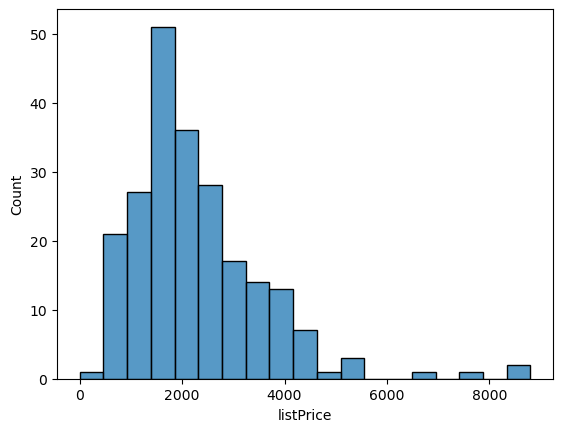

In [ ]:
sns.histplot(data=Properties_df, x='listPrice')

/Users/stevenzhou/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='listPrice', ylabel='Count'>

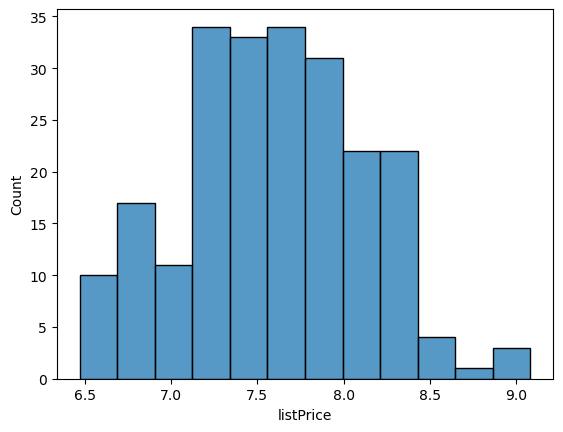

In [ ]:
sns.histplot(x=np.log(Properties_df['listPrice']))

<Axes: xlabel='mean_attraction_food', ylabel='Count'>

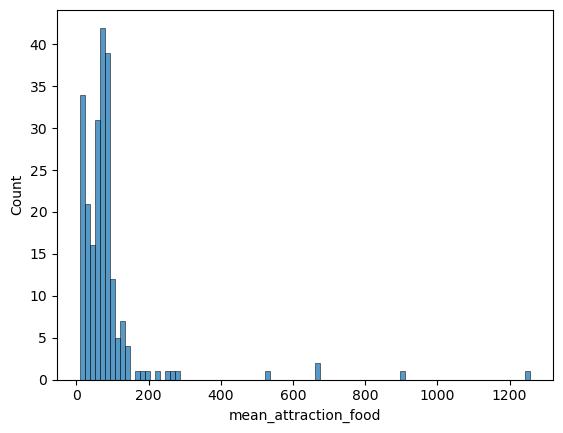

In [ ]:
sns.histplot(data=Properties_df, x='mean_attraction_food')

<Axes: xlabel='mean_attraction_groceries', ylabel='Count'>

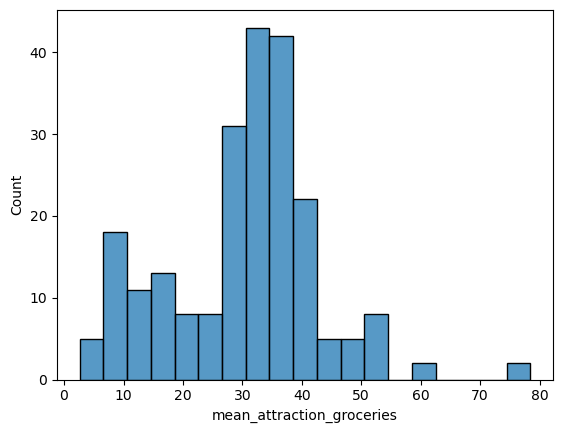

In [ ]:
sns.histplot(data=Properties_df, x='mean_attraction_groceries')

<Axes: xlabel='transit_time_cornell', ylabel='Count'>

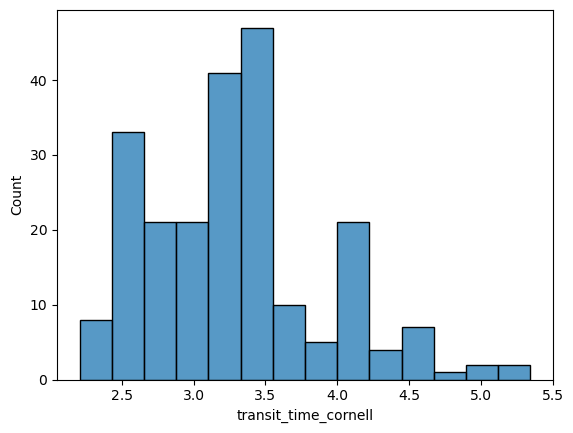

In [ ]:
sns.histplot(x=np.log(Properties_df['transit_time_cornell']))

<Axes: xlabel='transit_time_schools', ylabel='Count'>

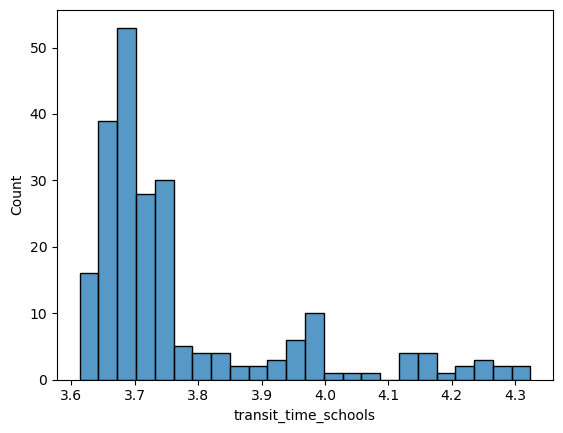

In [ ]:
sns.histplot(x=np.log(Properties_df['transit_time_schools']))

In [ ]:
reg_df = Properties_df.copy()

In [ ]:
#sns.histplot(x=reg_df['attraction_score'])

In [ ]:
dum_reg_df = pd.get_dummies(reg_df, columns=['type'], drop_first=True, dtype=int)
dum_reg_df['listPrice'] = dum_reg_df['listPrice'].replace([0, np.inf, -np.inf], np.nan)
dum_reg_df = dum_reg_df.dropna(subset=['listPrice'])

X = dum_reg_df[['beds','baths',
            'transit_time_cornell','mean_attraction_food','mean_attraction_groceries',
            #'log_mean_attraction_groceries','log_mean_attraction_food',
            'sqft',#'log_mean_attraction_groceries'
            #'type_condos','type_other','type_single_family'
               ]]
y = dum_reg_df['listPrice']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train['log_transit_time_cornell'] = np.log(X_train['transit_time_cornell'])
X_train['z_mean_attraction_food'] = (X_train['mean_attraction_food'] - X_train['mean_attraction_food'].mean()) / X_train['mean_attraction_food'].std()
X_train['z_mean_attraction_groceries'] = (X_train['mean_attraction_groceries'] - X_train['mean_attraction_groceries'].mean()) / X_train['mean_attraction_groceries'].std()
#reg_df['z_inverse_transit_time_school'] = (reg_df['inverse_transit_time_schools'] - reg_df['inverse_transit_time_schools'].mean()) / reg_df['inverse_transit_time_schools'].std()
#reg_df['attraction_score'] = 1*reg_df['z_mean_attraction_food']+10*reg_df['z_mean_attraction_groceries']+0.5*reg_df['z_inverse_transit_time_school']

#X_train['price_per_bed']

#X_train['price_per_bed'] = X_train['price_per_bed'].replace([0, np.inf, -np.inf], np.nan)

#X_train = X_train.dropna(subset=['price_per_bed'])

X_train = X_train.drop(['transit_time_cornell','mean_attraction_food','mean_attraction_groceries'], axis=1)

In [ ]:
X_test['log_transit_time_cornell'] = np.log(X_test['transit_time_cornell'])

X_test['z_mean_attraction_food'] = (X_test['mean_attraction_food'] - X_test['mean_attraction_food'].mean()) / X_test['mean_attraction_food'].std()
X_test['z_mean_attraction_groceries'] = (X_test['mean_attraction_groceries'] - X_test['mean_attraction_groceries'].mean()) / X_test['mean_attraction_groceries'].std()
#reg_df['z_inverse_transit_time_school'] = (reg_df['inverse_transit_time_schools'] - reg_df['inverse_transit_time_schools'].mean()) / reg_df['inverse_transit_time_schools'].std()
#reg_df['attraction_score'] = 1*reg_df['z_mean_attraction_food']+10*reg_df['z_mean_attraction_groceries']+0.5*reg_df['z_inverse_transit_time_school']

#X_test['price_per_bed'] = X_test['price_per_bed'].replace([0, np.inf, -np.inf], np.nan)

#X_test = X_test.dropna(subset=['price_per_bed'])

X_test = X_test.drop(['transit_time_cornell','mean_attraction_food','mean_attraction_groceries'], axis=1)

In [ ]:
#dum_reg_df[['beds','baths','attraction_score',
            #'transit_time_cornell',
            #'transit_time_schools',
            #'mean_attraction_food','mean_attraction_groceries',
#            'type_condos','type_other','type_single_family','listPrice']].corr()

In [ ]:
X_train_sm = sm.add_constant(X_train)
reg_model = sm.OLS(y_train,X_train_sm)
results = reg_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              listPrice   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     19.96
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           1.37e-17
Time:                        17:53:46   Log-Likelihood:                -1473.4
No. Observations:                 177   AIC:                             2961.
Df Residuals:                     170   BIC:                             2983.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        2183.9162    518.514      4.212      0.000    1160.361    3207.471
beds                          281.9980     68.524      4.115      0.000     146.731     417.265
baths                         192.4274    151.990      1.266      0.207    -107.604     492.459
sqft                            0.4892      0.119      4.112      0.000       0.254       0.724
log_transit_time_cornell     -387.5354    143.255     -2.705      0.008    -670.324    -104.747
z_mean_attraction_food       -158.7637     86.981     -1.825      0.070    -330.465      12.938
z_mean_attraction_groceries   158.0695     96.274      1.642      0.102     -31.977     348.116
==============================================================================
Omnibus:                       12.892   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               27.580
Skew:                          -0.262   Prob(JB):                     1.03e-06
Kurtosis:                       4.862   Cond. No.                     7.28e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
y_hat_train = results.predict(X_train_sm)
mae = mean_absolute_error(y_train, y_hat_train)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 717.3327274137573


In [ ]:
y_hat_train

73     1143.368782
151    1680.797112
95     2151.423039
117    1631.149465
75     2873.378262
          ...     
106    2099.251140
14     1903.588544
92     2157.814694
180    2697.252610
102    3825.267535
Length: 177, dtype: float64

In [ ]:
y_train

73     2368.5
151    2095.0
95     1900.0
117    1115.0
75     3500.0
        ...  
106     775.0
14     1815.0
92     1180.0
180    2550.0
102    3100.0
Name: listPrice, Length: 177, dtype: float64

In [ ]:
X_sm['log_transit_time_cornell'] = np.log(X_sm['transit_time_cornell'])

X_sm['z_mean_attraction_food'] = (X_sm['mean_attraction_food'] - X_sm['mean_attraction_food'].mean()) / X_sm['mean_attraction_food'].std()
X_sm['z_mean_attraction_groceries'] = (X_sm['mean_attraction_groceries'] - X_sm['mean_attraction_groceries'].mean()) / X_sm['mean_attraction_groceries'].std()
#reg_df['z_inverse_transit_time_school'] = (reg_df['inverse_transit_time_schools'] - reg_df['inverse_transit_time_schools'].mean()) / reg_df['inverse_transit_time_schools'].std()
#reg_df['attraction_score'] = 1*reg_df['z_mean_attraction_food']+10*reg_df['z_mean_attraction_groceries']+0.5*reg_df['z_inverse_transit_time_school']

#X_train['price_per_bed']

#X_train['price_per_bed'] = X_train['price_per_bed'].replace([0, np.inf, -np.inf], np.nan)

#X_train = X_train.dropna(subset=['price_per_bed'])

X_sm = X_sm.drop(['transit_time_cornell','mean_attraction_food','mean_attraction_groceries'], axis=1)

In [ ]:
X_sm = sm.add_constant(X_sm)
y_hat = results.predict(X_sm)

In [ ]:
X_sm

,const,beds,baths,sqft,log_transit_time_cornell,z_mean_attraction_food,z_mean_attraction_groceries
0,1.0,5.0,2.0,1300.0,3.495424,-0.214462,0.175695
1,1.0,6.0,2.0,3200.0,2.929948,-0.441063,-0.976263
2,1.0,6.0,2.0,2457.0,3.301495,-0.084099,0.651690
3,1.0,2.0,1.0,900.0,3.462076,-0.288185,-0.109679
4,1.0,1.5,1.5,894.0,3.962625,-0.546395,-1.783900
...,...,...,...,...,...,...,...
218,1.0,2.0,1.0,0.0,2.800157,0.000554,0.376912
219,1.0,3.0,2.0,1476.0,4.196756,-0.544861,-1.390692
220,1.0,1.5,1.0,725.0,2.205284,0.753940,0.855736
221,1.0,3.0,1.5,1144.5,4.179232,-0.542755,-1.373749


In [ ]:
y_hat

0      3321.894584
1      4606.332856
2      4299.553128
3      2067.326581
4      1601.977349
          ...     
218    1914.669775
219    2377.057719
220    2314.926404
221    2127.821125
222    1589.357720
Length: 222, dtype: float64

In [ ]:
y_hat = y_hat.rename("Predicted_listPrice")

In [ ]:
Prediction_Actual_df = pd.merge(Properties_df, y_hat, left_index=True, right_index=True)
Prediction_Actual_df

,address/street,baths,beds,coordinates/latitude,coordinates/longitude,garage,id,listPrice,is_manual,name,...,type,units,year_built,transit_time_cornell,transit_time_schools,mean_transit_time_food,mean_attraction_food,mean_transit_time_groceries,mean_attraction_groceries,Predicted_listPrice
0,809 S Aurora St,2.0,5.0,42.430851,-76.496069,0,4208852367,2625.0,False,NaN,...,single_family,1,NaN,32.964266,41.660656,28.614510,58.547235,32.677303,32.560692,3321.894584
1,419 Triphammer Rd,2.0,6.0,42.460409,-76.481516,4,4733433667,5000.0,False,NaN,...,single_family,1,1956.0,18.726652,39.538292,40.998225,30.616060,48.480457,18.194783,4606.332856
2,517 S Aurora St,2.0,6.0,42.435014,-76.494344,0,4090421202,4350.0,False,NaN,...,single_family,1,NaN,27.153197,37.905178,25.817097,74.615924,31.367246,38.496749,4299.553128
3,3 Hudson Pl,1.0,2.0,42.430688,-76.493156,0,4199200488,1600.0,False,NaN,...,single_family,1,NaN,31.883101,42.725910,30.343749,49.460075,34.693401,29.001822,2067.326581
4,600 Warren Rd Apt 4-2,1.5,1.5,42.477345,-76.467567,0,9934501911,1881.0,True,Warren Wood,...,apartment,181,NaN,52.595182,52.701795,65.957514,17.632660,66.080038,8.122852,1601.977349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,519 E Buffalo St,1.0,2.0,42.441285,-76.490701,0,3834217847,1200.0,False,"Moll Properties, Inc.",...,other,7,NaN,16.447236,38.573686,23.725115,85.050476,30.828639,35.070031,1914.669775
219,106 Wiedmaier Ct,2.0,3.0,42.413681,-76.449093,0,3610937531,3244.0,True,Ithacor,...,apartment,2,2007.0,66.470373,70.133653,67.054115,17.821761,69.579118,13.026491,2377.057719
220,409 College Ave,1.0,1.5,42.442255,-76.484963,0,9523596613,4095.0,True,"Student Agencies Properties, Inc.",...,apartment,64,NaN,9.072828,39.686916,26.436906,177.913893,35.709293,41.041379,2314.926404
221,103 Wiedmaier Ct,1.5,3.0,42.413895,-76.448010,0,3609558692,1450.0,True,Ithacor,...,apartment,2,2015.0,65.315703,68.978982,66.569621,18.081316,68.424448,13.237786,2127.821125


In [ ]:
Prediction_Actual_df['Value_for_Money'] =  Prediction_Actual_df['Predicted_listPrice'] - Prediction_Actual_df['listPrice']

In [ ]:
Prediction_Actual_df_sorted = Prediction_Actual_df.sort_values('Value_for_Money')

In [ ]:
Prediction_Actual_df_sorted.head(10)

,address/street,baths,beds,coordinates/latitude,coordinates/longitude,garage,id,listPrice,is_manual,name,...,year_built,transit_time_cornell,transit_time_schools,mean_transit_time_food,mean_attraction_food,mean_transit_time_groceries,mean_attraction_groceries,Predicted_listPrice,Deviation,Value_for_Money
69,111 Harvard Pl,3.0,7.0,42.440337,-76.481730,0,3886613762,7600.0,False,NaN,...,NaN,14.292562,43.223065,29.940792,58.085472,38.104173,26.901923,3695.131380,-3904.868620,-3904.868620
190,129 College Ave,3.0,8.0,42.439202,-76.484891,0,3875955703,8800.0,True,PPM Homes LLC,...,NaN,13.375487,41.243637,26.585765,71.264755,35.739544,34.623459,5545.347200,-3254.652800,-3254.652800
172,306 Bryant Ave,2.0,5.0,42.440925,-76.483697,0,3857918987,6566.0,False,"MLR Property Management, LLC",...,NaN,12.452978,41.708113,28.151533,72.743907,37.388394,29.447983,3983.821670,-2582.178330,-2582.178330
31,708 E Seneca-3 708 Sen St E # 1-2,3.0,10.0,42.440922,-76.489113,0,9648829532,8550.0,False,NaN,...,NaN,16.105692,39.238994,24.169143,84.503020,31.349471,35.349581,6035.381246,-2514.618754,-2514.618754
184,522 Stewart Ave,2.5,5.0,42.444431,-76.489685,0,9089162976,5500.0,True,"MLR Property Management, LLC",...,NaN,11.851989,38.358421,25.747438,64.458568,33.987825,29.227845,3128.757848,-2371.242152,-2371.242152
41,218 Delaware Ave Apt 4,2.0,5.0,42.440521,-76.483574,0,9004188671,5250.0,False,NaN,...,NaN,13.206969,42.295896,28.801401,65.576199,37.977577,28.065965,2974.427349,-2275.572651,-2275.572651
200,112 Summit St,3.0,3.0,42.442169,-76.483081,0,4465034930,5100.5,True,The Lux and Lofts,...,NaN,11.306158,41.367321,28.472981,67.172065,37.691251,28.151504,3184.536579,-1915.963421,-1915.963421
183,309 S Aurora St,2.0,3.5,42.437196,-76.494479,0,3992635369,4550.0,False,PPM Homes LLC,...,NaN,26.448578,40.373926,24.115934,99.750411,30.067403,39.659886,2727.655301,-1822.344699,-1822.344699
220,409 College Ave,1.0,1.5,42.442255,-76.484963,0,9523596613,4095.0,True,"Student Agencies Properties, Inc.",...,NaN,9.072828,39.686916,26.436906,177.913893,35.709293,41.041379,2314.926404,-1780.073596,-1780.073596
194,601 E State St,2.0,4.0,42.438908,-76.489525,0,3913147113,4400.0,True,"MLR Property Management, LLC",...,NaN,18.335715,39.464667,24.193922,80.831291,31.156001,33.994041,2620.766740,-1779.233260,-1779.233260


In [ ]:
Prediction_Actual_df_sorted.tail(10)

,address/street,baths,beds,coordinates/latitude,coordinates/longitude,garage,id,listPrice,is_manual,name,...,year_built,transit_time_cornell,transit_time_schools,mean_transit_time_food,mean_attraction_food,mean_transit_time_groceries,mean_attraction_groceries,Predicted_listPrice,Deviation,Value_for_Money
99,124 Roberts Pl,2.0,3.0,42.453167,-76.484934,0,4335817125,1250.0,False,NaN,...,NaN,12.558746,37.426475,34.995643,36.355633,42.379507,20.671338,3107.590153,1857.590153,1857.590153
23,202 Linden Ave Unit 303,1.0,4.0,42.439472,-76.484375,0,9777901913,900.0,False,NaN,...,NaN,13.895580,41.669672,27.054276,67.821614,35.140373,33.095443,3035.217735,2135.217735,2135.217735
153,426 Eddy St,2.0,4.5,42.442211,-76.487778,0,9167320806,920.0,False,Landlords Association,...,0.0,13.094258,39.532163,25.236662,111.025250,34.837493,60.356144,3187.491974,2267.491974,2267.491974
66,205 Williams St,2.0,7.0,42.442171,-76.488493,0,3844018790,995.0,False,NaN,...,NaN,13.801815,39.286552,24.961135,90.720028,33.447571,37.130628,3603.859988,2608.859988,2608.859988
68,126 College Ave Unit 201,2.0,6.0,42.438778,-76.485321,0,9320578554,1417.0,False,NaN,...,NaN,13.858124,41.664518,27.051552,67.737709,34.033401,33.884292,4119.772228,2702.772228,2702.772228
26,126 College Ave Unit 401,2.0,6.0,42.438778,-76.485321,0,9708488612,1417.0,False,NaN,...,NaN,13.858124,41.664518,27.051552,67.737709,34.033401,33.884292,4119.772228,2702.772228,2702.772228
5,114 Stewart Ave,3.0,7.0,42.440100,-76.489955,0,3898203471,850.0,False,NaN,...,NaN,17.515751,39.051478,23.785551,82.973916,30.933776,34.703518,3683.150871,2833.150871,2833.150871
46,104 Lake Ave,4.0,7.0,42.444748,-76.499762,0,9843308796,825.0,False,NaN,...,NaN,27.959753,40.398119,25.478486,101.234997,31.648447,38.790754,3722.626795,2897.626795,2897.626795
47,214 Dryden Rd,4.0,7.0,42.441896,-76.484229,0,9725975963,850.0,False,NaN,...,NaN,11.132412,40.725175,26.904703,116.633527,36.193186,33.580286,3993.633197,3143.633197,3143.633197
175,416 Hudson St # 416HUD,2.0,6.0,42.435165,-76.492434,0,4079390483,725.0,True,PPM Homes LLC,...,NaN,24.660424,37.738180,25.912907,70.232954,31.878800,35.765566,4113.700093,3388.700093,3388.700093


In [ ]:
top_low_10 = pd.concat([Prediction_Actual_df_sorted.head(10), Prediction_Actual_df_sorted.tail(10)])
top_low_10

,address/street,baths,beds,coordinates/latitude,coordinates/longitude,garage,id,listPrice,is_manual,name,...,year_built,transit_time_cornell,transit_time_schools,mean_transit_time_food,mean_attraction_food,mean_transit_time_groceries,mean_attraction_groceries,Predicted_listPrice,Deviation,Value_for_Money
69,111 Harvard Pl,3.0,7.0,42.440337,-76.481730,0,3886613762,7600.0,False,NaN,...,NaN,14.292562,43.223065,29.940792,58.085472,38.104173,26.901923,3695.131380,-3904.868620,-3904.868620
190,129 College Ave,3.0,8.0,42.439202,-76.484891,0,3875955703,8800.0,True,PPM Homes LLC,...,NaN,13.375487,41.243637,26.585765,71.264755,35.739544,34.623459,5545.347200,-3254.652800,-3254.652800
172,306 Bryant Ave,2.0,5.0,42.440925,-76.483697,0,3857918987,6566.0,False,"MLR Property Management, LLC",...,NaN,12.452978,41.708113,28.151533,72.743907,37.388394,29.447983,3983.821670,-2582.178330,-2582.178330
31,708 E Seneca-3 708 Sen St E # 1-2,3.0,10.0,42.440922,-76.489113,0,9648829532,8550.0,False,NaN,...,NaN,16.105692,39.238994,24.169143,84.503020,31.349471,35.349581,6035.381246,-2514.618754,-2514.618754
184,522 Stewart Ave,2.5,5.0,42.444431,-76.489685,0,9089162976,5500.0,True,"MLR Property Management, LLC",...,NaN,11.851989,38.358421,25.747438,64.458568,33.987825,29.227845,3128.757848,-2371.242152,-2371.242152
41,218 Delaware Ave Apt 4,2.0,5.0,42.440521,-76.483574,0,9004188671,5250.0,False,NaN,...,NaN,13.206969,42.295896,28.801401,65.576199,37.977577,28.065965,2974.427349,-2275.572651,-2275.572651
200,112 Summit St,3.0,3.0,42.442169,-76.483081,0,4465034930,5100.5,True,The Lux and Lofts,...,NaN,11.306158,41.367321,28.472981,67.172065,37.691251,28.151504,3184.536579,-1915.963421,-1915.963421
183,309 S Aurora St,2.0,3.5,42.437196,-76.494479,0,3992635369,4550.0,False,PPM Homes LLC,...,NaN,26.448578,40.373926,24.115934,99.750411,30.067403,39.659886,2727.655301,-1822.344699,-1822.344699
220,409 College Ave,1.0,1.5,42.442255,-76.484963,0,9523596613,4095.0,True,"Student Agencies Properties, Inc.",...,NaN,9.072828,39.686916,26.436906,177.913893,35.709293,41.041379,2314.926404,-1780.073596,-1780.073596
194,601 E State St,2.0,4.0,42.438908,-76.489525,0,3913147113,4400.0,True,"MLR Property Management, LLC",...,NaN,18.335715,39.464667,24.193922,80.831291,31.156001,33.994041,2620.766740,-1779.233260,-1779.233260


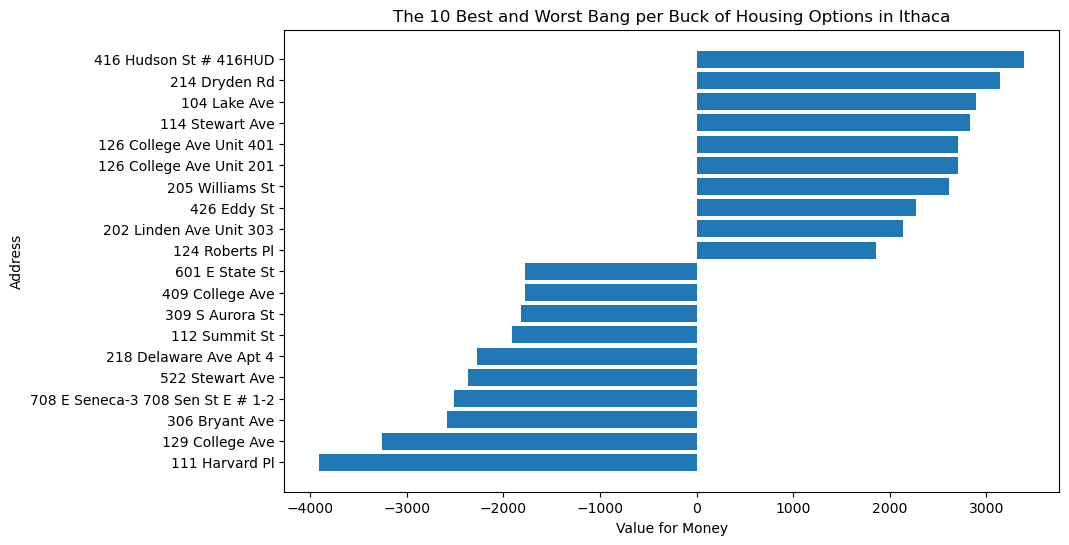

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(top_low_10['address/street'], top_low_10['Value_for_Money'])
plt.xlabel('Value for Money')
plt.ylabel('Address')
plt.title('The 10 Best and Worst Bang per Buck of Housing Options in Ithaca')
plt.show()

In [ ]:
Prediction_Actual_df_sorted_gdf = gpd.GeoDataFrame(
    Prediction_Actual_df_sorted, geometry=gpd.points_from_xy(Prediction_Actual_df_sorted['coordinates/longitude'], Prediction_Actual_df_sorted['coordinates/latitude']), crs="EPSG:4326"
)

In [ ]:
Prediction_Actual_df_sorted_gdf

,address/street,baths,beds,coordinates/latitude,coordinates/longitude,garage,id,listPrice,is_manual,name,...,year_built,transit_time_cornell,transit_time_schools,mean_transit_time_food,mean_attraction_food,mean_transit_time_groceries,mean_attraction_groceries,Predicted_listPrice,Deviation,geometry
175,416 Hudson St # 416HUD,2.0,6.0,42.435165,-76.492434,0,4079390483,725.0,True,PPM Homes LLC,...,NaN,24.660424,37.738180,25.912907,70.232954,31.878800,35.765566,4113.700093,-3388.700093,POINT (-76.49243 42.43516)
47,214 Dryden Rd,4.0,7.0,42.441896,-76.484229,0,9725975963,850.0,False,NaN,...,NaN,11.132412,40.725175,26.904703,116.633527,36.193186,33.580286,3993.633197,-3143.633197,POINT (-76.48423 42.44190)
46,104 Lake Ave,4.0,7.0,42.444748,-76.499762,0,9843308796,825.0,False,NaN,...,NaN,27.959753,40.398119,25.478486,101.234997,31.648447,38.790754,3722.626795,-2897.626795,POINT (-76.49976 42.44475)
5,114 Stewart Ave,3.0,7.0,42.440100,-76.489955,0,3898203471,850.0,False,NaN,...,NaN,17.515751,39.051478,23.785551,82.973916,30.933776,34.703518,3683.150871,-2833.150871,POINT (-76.48995 42.44010)
68,126 College Ave Unit 201,2.0,6.0,42.438778,-76.485321,0,9320578554,1417.0,False,NaN,...,NaN,13.858124,41.664518,27.051552,67.737709,34.033401,33.884292,4119.772228,-2702.772228,POINT (-76.48532 42.43878)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,522 Stewart Ave,2.5,5.0,42.444431,-76.489685,0,9089162976,5500.0,True,"MLR Property Management, LLC",...,NaN,11.851989,38.358421,25.747438,64.458568,33.987825,29.227845,3128.757848,2371.242152,POINT (-76.48968 42.44443)
31,708 E Seneca-3 708 Sen St E # 1-2,3.0,10.0,42.440922,-76.489113,0,9648829532,8550.0,False,NaN,...,NaN,16.105692,39.238994,24.169143,84.503020,31.349471,35.349581,6035.381246,2514.618754,POINT (-76.48911 42.44092)
172,306 Bryant Ave,2.0,5.0,42.440925,-76.483697,0,3857918987,6566.0,False,"MLR Property Management, LLC",...,NaN,12.452978,41.708113,28.151533,72.743907,37.388394,29.447983,3983.821670,2582.178330,POINT (-76.48370 42.44093)
190,129 College Ave,3.0,8.0,42.439202,-76.484891,0,3875955703,8800.0,True,PPM Homes LLC,...,NaN,13.375487,41.243637,26.585765,71.264755,35.739544,34.623459,5545.347200,3254.652800,POINT (-76.48489 42.43920)


<Axes: >

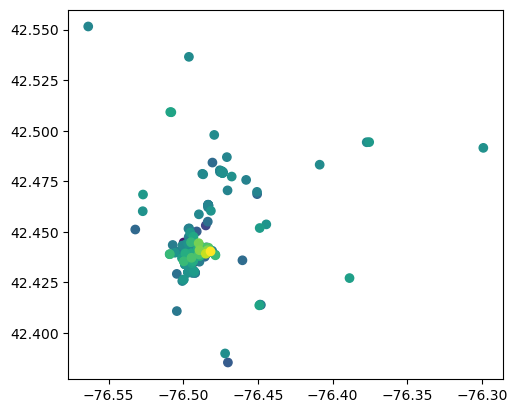

In [ ]:
Prediction_Actual_df_sorted_gdf.plot('Deviation')

<Axes: xlabel='listPrice', ylabel='None'>

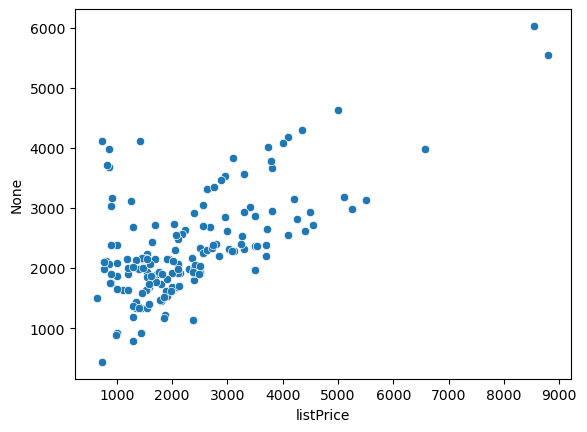

In [ ]:
sns.scatterplot(x=y_train, y=y_hat_train)

<Axes: xlabel='None', ylabel='None'>

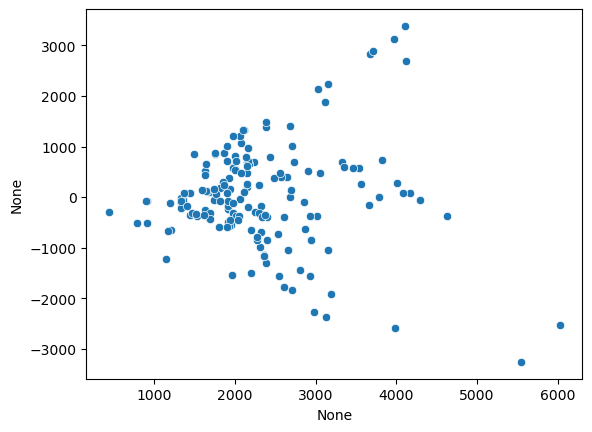

In [ ]:
resid_train = y_hat_train - y_train
sns.scatterplot(x=y_hat_train, y=resid_train)

In [ ]:
X_test_sm = sm.add_constant(X_test)
y_hat_test = results.predict(X_test_sm)
mae = mean_absolute_error(y_test, y_hat_test)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 657.7664219511964


## NN

In [ ]:
X = dum_reg_df[['beds','baths',
            'transit_time_cornell','mean_attraction_food','mean_attraction_groceries',
            #'log_mean_attraction_groceries','log_mean_attraction_food',
            'sqft',#'log_mean_attraction_groceries'
            #'type_condos','type_other','type_single_family'
               ]]
y = dum_reg_df['listPrice']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train['log_transit_time_cornell'] = np.log(X_train['transit_time_cornell'])
X_test['log_transit_time_cornell'] = np.log(X_test['transit_time_cornell'])

y_train = np.log(y_train)
y_test = np.log(y_test)

X_train['log_mean_attraction_food'] = np.log(X_train['mean_attraction_food'])
X_test['log_mean_attraction_food'] = np.log(X_test['mean_attraction_food'])

X_train['log_mean_attraction_groceries'] = np.log(X_train['mean_attraction_groceries'])
X_test['log_mean_attraction_groceries'] = np.log(X_test['mean_attraction_groceries'])

X_train = X_train.drop(['transit_time_cornell','mean_attraction_food','mean_attraction_groceries'], axis=1)
X_test = X_test.drop(['transit_time_cornell','mean_attraction_food','mean_attraction_groceries'], axis=1)

In [ ]:
model = Sequential([
    Dense(18), 
    Dense(32), 
    Dense(44),
    Dense(1)  # Single output node for regression
])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
6/6 [==============================] - 1s 23ms/step - loss: 13843.8701 - val_loss: 6203.8569
Epoch 2/20
6/6 [==============================] - 0s 5ms/step - loss: 8001.6851 - val_loss: 47.5676
Epoch 3/20
6/6 [==============================] - 0s 5ms/step - loss: 2575.8828 - val_loss: 1756.2483
Epoch 4/20
6/6 [==============================] - 0s 5ms/step - loss: 1106.4834 - val_loss: 246.9794
Epoch 5/20
6/6 [==============================] - 0s 6ms/step - loss: 887.2444 - val_loss: 126.1245
Epoch 6/20
6/6 [==============================] - 0s 6ms/step - loss: 168.1869 - val_loss: 331.5870
Epoch 7/20
6/6 [==============================] - 0s 6ms/step - loss: 334.6973 - val_loss: 39.4084
Epoch 8/20
6/6 [==============================] - 0s 7ms/step - loss: 139.9098 - val_loss: 71.8153
Epoch 9/20
6/6 [==============================] - 0s 7ms/step - loss: 67.8382 - val_loss: 83.3087
Epoch 10/20
6/6 [==============================] - 0s 7ms/step - loss: 71.3745 - val_loss: 37.880

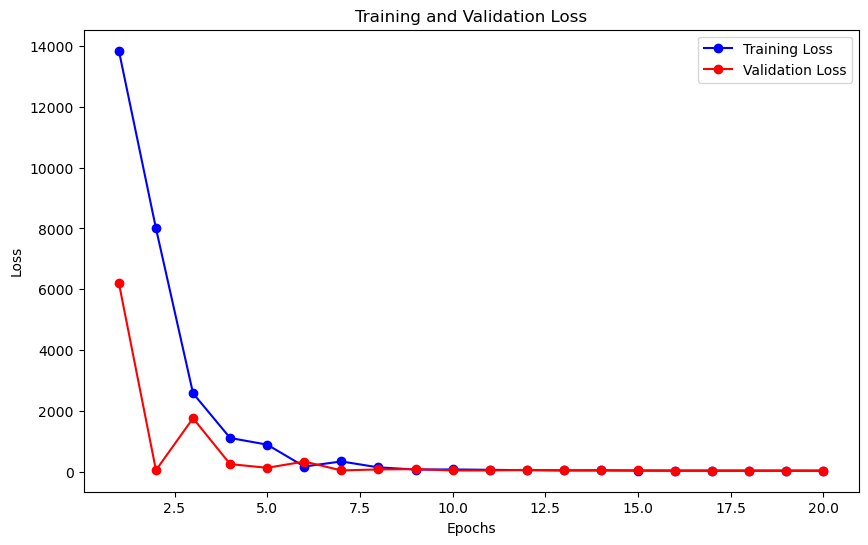

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

2/2 [==============================] - 0s 3ms/step - loss: 21.8830
Test Loss: 21.882965087890625


In [ ]:
# Predicting the values for the test set
y_pred = model.predict(X_test)

# Calculating Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")


2/2 [==============================] - 0s 2ms/step
Mean Absolute Error: 3.7184368223537327


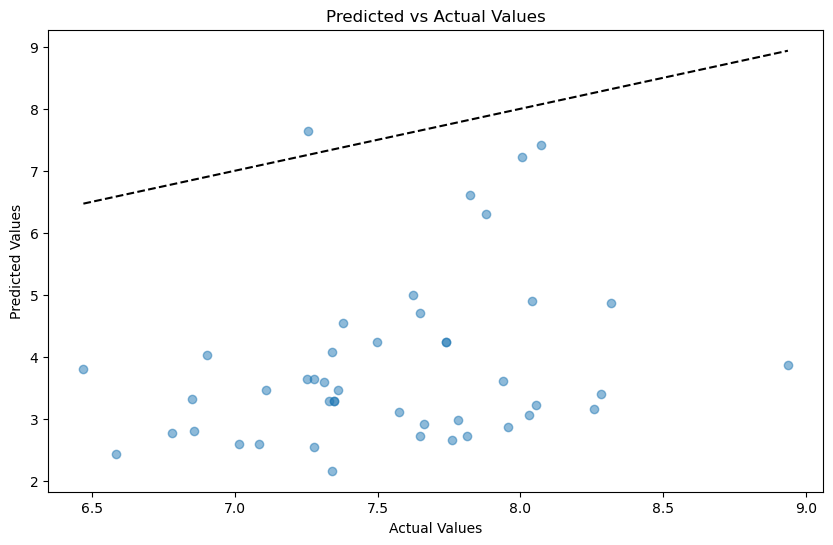

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # Diagonal line
plt.show()